# Advanced Programming for AI

# HW 11: Ordinary Least Squares and Regression

## This homework problem will use a data set with two predictors and one target. The target is `arm_length` and the predictors are `height` and `weight`. The dataset for this hw is `hw11_data.csv`

In [1]:
import pandas as pd
df = pd.read_csv('hw11_data.csv',index_col=0)
y = df['arm_length']
X = df.drop('arm_length',axis=1)
df.head()

,height,weight,arm_length
0,171.026667,46.069000,64.730799
1,176.620540,58.075316,67.089599
2,171.496360,54.795167,67.029323
3,177.692676,74.944373,68.612269
4,157.147998,51.509617,56.162113


# Problem 1: Make a plot like whats shown below to demonstrate of the utility of each feature in predicting the target. Include all labels and metrics.

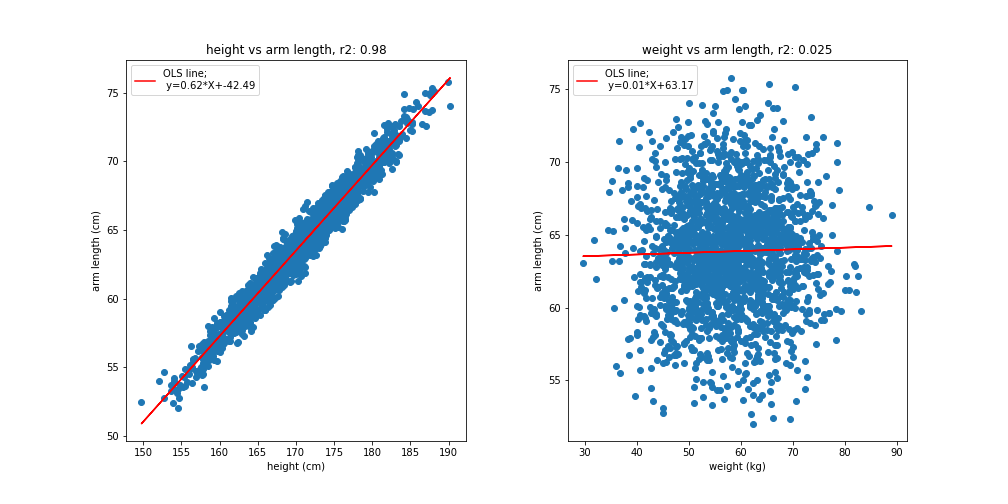

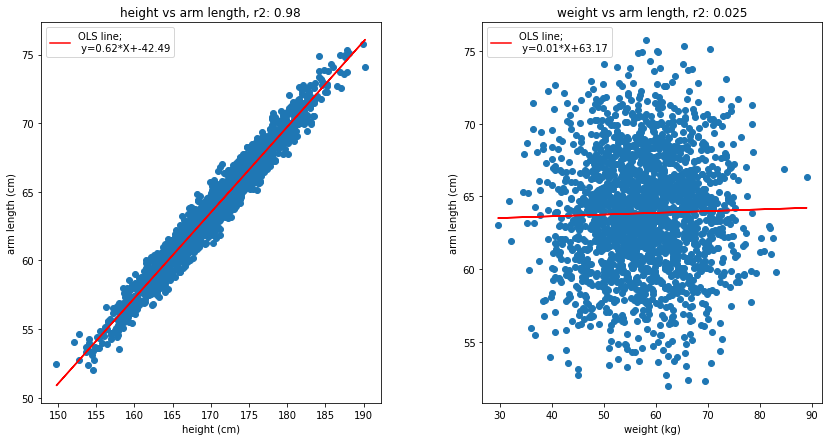

In [2]:
from scipy import stats
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df['height'],df['arm_length'])
line1 = slope1*df['height']+intercept1
plt.title('height vs arm length, r2: {}'.format(round(r_value1,3)))
plt.plot(df['height'],line1,color='red',label='OLS line;\n y={0}*X+{1}'.format(round(slope1,2),round(intercept1,2)))
plt.scatter(df['height'],df['arm_length'])
plt.xlabel('height (cm)')
plt.ylabel('arm length (cm)')
plt.legend()

plt.subplot(1,2,2)
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(df['weight'],df['arm_length'])
line2 = slope2*df['weight']+intercept2
plt.title('weight vs arm length, r2: {}'.format(round(r_value2,3)))
plt.plot(df['weight'],line2,color='red',label='OLS line;\n y={0}*X+{1}'.format(round(slope2,2),round(intercept2,2)))
plt.scatter(df['weight'],df['arm_length'])
plt.xlabel('weight (kg)')
plt.ylabel('arm length (cm)')
plt.legend()
plt.subplots_adjust(wspace=0.3)
plt.show()

# Problem 2: Make a class that produces a regression model report, independent of the number of predictors (it would work for 2,3.. N features) that produces a graphic like whats attached below.

Do this in two steps

1. Produce a parent class `best_regressor` class that uses `GridSearchCV` to find the best parameters for a regression model (if it has parameters).

2. Produce a child class `regression_report(best_regressor)` that uses the best model from `best_regressor` to produce the model report as seen below.

### * Hint, this is just like problem 3 in HW 10.
### * Hint, `best_regressor` should look like;
    
`class best_regressor:
    def __init__(self,model,data,target,parameters,metric='r2',test_size=0.2,cv=5):
        self.model = model
        self.data = data
        self.target = target
        self.metric = metric.lower()
        if parameters == None:
            parameters = {}
        self.parameters = parameters
        self.test_size=test_size
        self.cv=cv
`    
 



# The output should look like

`from sklearn.linear_model import LinearRegression
parameters = None
rr = regression_report(LinearRegression(),X,y,parameters)
rr.report()`

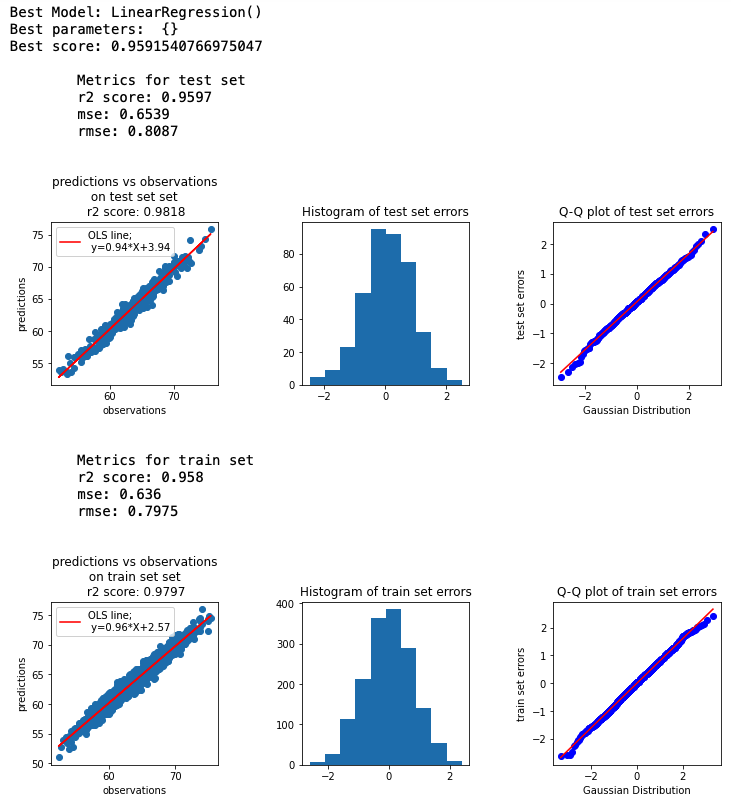

In [3]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error,make_scorer
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

class best_regressor:
    def __init__(self,model,data,target,parameters,metric='r2',test_size=0.2,cv=5):
        self.model = model
        self.data = data
        self.target = target
        self.metric = metric.lower()
        if parameters == None:
            parameters = {}
        self.parameters = parameters
        self.test_size=test_size
        self.cv=cv
        
    def split(self):
        self.X_train,self.X_test,self.y_train,self.y_test=train_test_split(self.data,self.target,test_size=self.test_size)
    
    def run(self):
        self.split()
        d = {'r2':r2_score,'mse':mean_squared_error}
        if self.metric=='r2':
            greater_is_better=True
        else:
            greater_is_better=False
        scorer = make_scorer(d[self.metric],greater_is_better=greater_is_better)
        gs = GridSearchCV(estimator=self.model,param_grid=self.parameters,cv=self.cv,scoring=scorer)
        gs.fit(self.X_train,self.y_train)
        self.best_model = gs.best_estimator_
        self.best_score = gs.best_score_
        self.best_params = gs.best_params_
        print('Best Model: {}'.format(self.best_model))
        print('Best parameters: ',str(self.best_params))
        print('Best score: {}'.format(self.best_score))
        return

class regression_report(best_regressor):
    def __init__(self,model,data,target,parameters,metric='r2',test_size=0.2,cv=5):
        super().__init__(model,data,target,parameters,metric,test_size,cv)
        super().run()
        self.best_model.fit(self.X_train,self.y_train)
        self.y_pred_test = self.best_model.predict(self.X_test)
        self.y_pred_train = self.best_model.predict(self.X_train)
        
    def string_report(self,y_pred,y_obs,label):
        r2 = r2_score(y_pred,y_obs)
        mse = mean_squared_error(y_pred,y_obs)
        rmse = np.sqrt(mse)
        
        metric_text = '''
        Metrics for {0}
        r2 score: {1}
        mse: {2}
        rmse: {3}
        '''.format(label,round(r2,4),round(mse,4),round(rmse,4))
        print(metric_text)
        return metric_text
    
    def plot_predictions_vs_observations(self,y_pred,y_obs,label):
        slope, intercept, r_value, p_value, std_err = stats.linregress(y_obs,y_pred)
        plt.title('predictions vs observations\n on {0} set \n r2 score: {1}'.format(label,round(r_value,4)))
        plt.scatter(y_obs,y_pred)
        plt.ylabel('predictions')
        plt.xlabel('observations')
        line = slope*y_obs+intercept
        plt.plot(y_obs,line,color='red',label='OLS line;\n y={0}*X+{1}'.format(round(slope,2),round(intercept,2)))
        plt.legend()
        
    def graphic_report(self,y_pred,y_obs,label):
        errors = y_pred-y_obs
        plt.subplot(1,3,1)
        self.plot_predictions_vs_observations(y_pred,y_obs,label)
        plt.subplot(1,3,2)
        plt.title('Histogram of {} errors'.format(label))
        plt.hist(errors)
        plt.subplot(1,3,3)
        stats.probplot(errors,plot=plt)
        plt.title('Q-Q plot of {} errors'.format(label))
        plt.ylabel('{} errors'.format(label))
        plt.xlabel('Gaussian Distribution')
        plt.subplots_adjust(wspace=0.5)
        plt.show()
        
    def report(self):
        figsize = (12,3)
        plt.figure(figsize=figsize)
        plt.subplot(2,1,1)
        self.string_report(self.y_pred_test,self.y_test,'test set')
        self.graphic_report(self.y_pred_test,self.y_test,'test set')
        plt.figure(figsize=figsize)
        plt.subplot(2,1,2)
        self.string_report(self.y_pred_train,self.y_train,'train set')
        self.graphic_report(self.y_pred_train,self.y_train,'train set')

Best Model: LinearRegression()
Best parameters:  {}
Best score: 0.9605020230127173

        Metrics for test set
        r2 score: 0.9581
        mse: 0.6198
        rmse: 0.7873
        


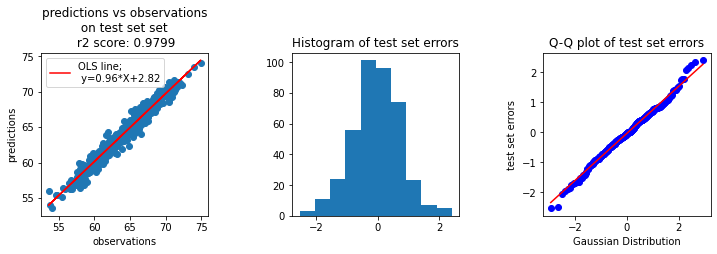


        Metrics for train set
        r2 score: 0.959
        mse: 0.6432
        rmse: 0.802
        


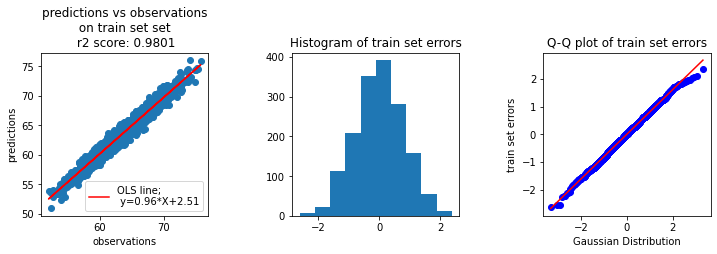

In [4]:
from sklearn.linear_model import LinearRegression
parameters = None
rr = regression_report(LinearRegression(),X,y,parameters)
rr.report()